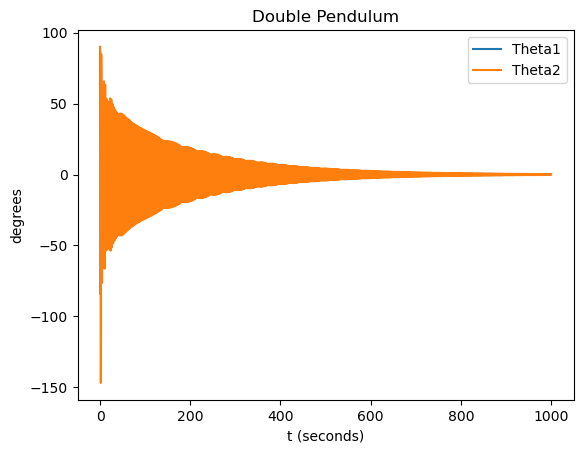

Epoch 1, Train Loss: 0.042792879872502305, Test Loss: 0.003475983371026814
Epoch 2, Train Loss: 0.0029534483926270056, Test Loss: 0.0025673014984931796
Epoch 3, Train Loss: 0.002657803024064649, Test Loss: 0.0025231832172721625
Epoch 4, Train Loss: 0.002613469956732179, Test Loss: 0.002484759304206818
Epoch 5, Train Loss: 0.002578256417355324, Test Loss: 0.002451982325874269
Epoch 6, Train Loss: 0.002530620974564069, Test Loss: 0.0024089959159027787
Epoch 7, Train Loss: 0.00248514352102034, Test Loss: 0.002369702502619475
Epoch 8, Train Loss: 0.0024524359976419727, Test Loss: 0.0023223047668579967
Epoch 9, Train Loss: 0.0024411099761523104, Test Loss: 0.0023024301801342515
Epoch 10, Train Loss: 0.002361539510594731, Test Loss: 0.002243299182737246
Epoch 11, Train Loss: 0.002317905263987848, Test Loss: 0.002207057923078537
Epoch 12, Train Loss: 0.00230439637498175, Test Loss: 0.002265530452132225
Epoch 13, Train Loss: 0.0022575239669783294, Test Loss: 0.002134025824489072
Epoch 14, Trai

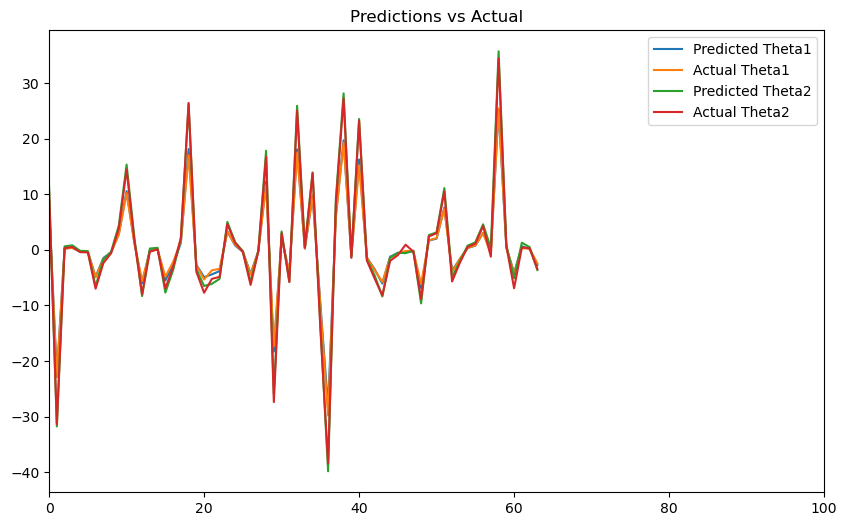

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2) - 2 * sin(theta1 - theta2) * m2 * 
               (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1) + omega2**2 * L2 * m2 * 
                                           cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return array([ftheta1, fomega1, ftheta2, fomega2], float)

a = 0.0
b = 1000
N = 3000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)

q = np.array([pi / 2, 0, pi / 2, 0], float)

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / pi
    theta2_points[i] = q[2] * 180 / pi

    k1 = h * f(q, t, L1, L2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
    k4 = h * f(q + k3, t + h, L1, L2)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.title("Double Pendulum")
plt.xlabel("t (seconds)")
plt.ylabel("degrees")
plt.legend()
plt.show()

data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

data = np.load('pendulum_data.npy')

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

input_size = 2
hidden_layer_size = 100
output_size = 2

model = LSTMModel(input_size, hidden_layer_size, output_size)

for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)
    elif 'bias' in name:
        nn.init.zeros_(param)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0

def train_model(model, train_loader, test_loader, num_epochs):
    global best_loss, patience_counter
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for sequences, targets in test_loader:
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')
        
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break
    
    if best_model:
        model.load_state_dict(best_model)

NUM_EPOCHS = 100
train_model(model, train_loader, test_loader, NUM_EPOCHS)

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            y_pred = model(sequences)
            loss = torch.sqrt(loss_function(y_pred, targets))
            test_loss += loss.item()
            all_preds.append(y_pred)
            all_targets.append(targets)
    
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test RMSE: {avg_test_loss}')
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    
    r2 = r2_score(all_targets, all_preds)
    print(f'R^2 Score: {r2}')

evaluate_model(model, test_loader)

model.eval()
with torch.no_grad():
    for sequences, targets in test_loader:
        y_pred = model(sequences)
        break

y_pred_original = scaler.inverse_transform(y_pred.numpy())
targets_original = scaler.inverse_transform(targets.numpy())

# Ensure there are enough points to plot up to 100 timesteps
plot_range = min(100, len(y_pred_original), len(targets_original))

plt.figure(figsize=(10, 6))
plt.plot(y_pred_original[:plot_range, 0], label='Predicted Theta1')
plt.plot(targets_original[:plot_range, 0], label='Actual Theta1')
plt.plot(y_pred_original[:plot_range, 1], label='Predicted Theta2')
plt.plot(targets_original[:plot_range, 1], label='Actual Theta2')
plt.legend()
plt.xlim(0, 100)  # Extend x-axis to 100 time steps
plt.title('Predictions vs Actual')
plt.show()
